# Cultura Pricing Assistant

### Ahsanuddin Mohammed

## 1. Combining Google Trends datasets

In [1]:
import pandas as pd
import os

base_path = "google_trends"

region_map = {
    "multiTimeline.csv": "chicago",
    "multiTimeline-2.csv": "austin",
    "multiTimeline-3.csv": "new jersey",
    "multiTimeline-4.csv": "salt lake city"
}

all_data = []

for keyword in os.listdir(base_path):
    keyword_path = os.path.join(base_path, keyword)

    # Skip .DS_Store or non-folders
    if not os.path.isdir(keyword_path):
        continue

    for file in os.listdir(keyword_path):
        if not file.startswith("multiTimeline"):
            continue

        file_path = os.path.join(keyword_path, file)

        # Skipping first 2 rows
        df = pd.read_csv(file_path, skiprows=2)

        # Renaming columns
        df.columns = ["date", "trend_score"]

        df["keyword"] = keyword
        df["region"] = region_map[file]

        all_data.append(df)

# Combine everything
trends_df = pd.concat(all_data, ignore_index=True)

## 2. Data Preparation

In [2]:
# Convert types
trends_df["date"] = pd.to_datetime(trends_df["date"])
trends_df["trend_score"] = pd.to_numeric(trends_df["trend_score"], errors="coerce")

# Drop null rows
trends_df = trends_df.dropna()
trends_df.to_csv("google_trends.csv", index=False)
trends_df.head()

,date,trend_score,keyword,region
0,2024-12-08,83,meditation,chicago
1,2024-12-15,73,meditation,chicago
2,2024-12-22,58,meditation,chicago
3,2024-12-29,79,meditation,chicago
4,2025-01-05,84,meditation,chicago


In [3]:
events = pd.read_csv("event_pricing.csv")

# Normalize text columns
events["event_type"] = events["event_type"].str.lower().str.strip()
events["pricing_model"] = events["pricing_model"].str.lower().str.strip()
events["region"] = events["region"].str.lower().str.strip()

events.head()

,region,event_type,price_usd,duration_hours,pricing_model,platform
0,austin,community care,46,3.00,tiered,eventbrite
1,austin,meditation,19,1.00,tiered,eventbrite
2,austin,sound bath,45,1.25,fixed,eventbrite
3,austin,journaling,31,2.00,fixed,eventbrite
4,austin,yoga sculpt,44,1.50,fixed,eventbrite


## 3. Model Features

In [4]:
# i) Community Accessibility
accessibility_map = {
    "donation": 3,
    "tiered": 2,
    "fixed": 1
}

events["community_accessibility"] = events["pricing_model"].map(accessibility_map)

In [5]:
# ii) Event Intensity
intensity_map = {
    "journaling": 1,
    "meditation": 1,
    "mindfulness": 1,
    "mental health": 1,
    "sound bath": 1,
    "healing circle": 2,
    "community care": 2,
    "yoga sculpt": 3,
    "breathwork": 3,
    "pilates": 3
}

events["event_intensity"] = events["event_type"].map(intensity_map)

In [6]:
# iii) Cost-OF-Living Mulitplier
col_multiplier = {
    "chicago": 1.00,
    "austin": 0.95,
    "new jersey": 1.05,
    "salt lake city": 0.90
}

events["col_multiplier"] = events["region"].map(col_multiplier)

In [7]:
# iv) Trend Strength
trends = pd.read_csv("google_trends.csv")

trend_agg = (
    trends
    .groupby(["keyword", "region"])["trend_score"]
    .mean()
    .reset_index()
    .rename(columns={"trend_score": "trend_strength"})
)

events = events.merge(
    trend_agg,
    left_on=["event_type", "region"],
    right_on=["keyword", "region"],
    how="left"
)

In [8]:
events[[
    "price_usd",
    "duration_hours",
    "event_intensity",
    "community_accessibility",
    "col_multiplier",
    "trend_strength"
]].describe()

,price_usd,duration_hours,event_intensity,community_accessibility,col_multiplier,trend_strength
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,33.275000,2.106250,1.800000,1.500000,0.975000,40.822170
std,15.086057,1.550318,0.882886,0.751068,0.056614,30.454763
min,7.000000,0.750000,1.000000,1.000000,0.900000,1.886792
25%,22.750000,1.250000,1.000000,1.000000,0.937500,8.169811
50%,34.500000,1.750000,1.500000,1.000000,0.975000,43.367925
75%,44.250000,2.000000,3.000000,2.000000,1.012500,73.292453
max,65.000000,8.000000,3.000000,3.000000,1.050000,83.754717


## 4. Comparing Models

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [10]:
# Target
y = events["price_usd"]

# Features
X = events[
    [
        "duration_hours",
        "event_intensity",
        "community_accessibility",
        "col_multiplier",
        "trend_strength"
    ]
]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [11]:
# 1) Linear Regression
lin_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

lin_model.fit(X_train, y_train)

lin_preds = lin_model.predict(X_test)

lin_rmse = np.sqrt(mean_squared_error(y_test, lin_preds))
lin_mae = mean_absolute_error(y_test, lin_preds)

In [12]:
# 2) Ridge Regression
ridge_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

ridge_model.fit(X_train, y_train)

ridge_preds = ridge_model.predict(X_test)

ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
ridge_mae = mean_absolute_error(y_test, ridge_preds)

In [13]:
# 3) Random Forest
rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_mae = mean_absolute_error(y_test, rf_preds)

In [14]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge Regression", "Random Forest"],
    "RMSE": [lin_rmse, ridge_rmse, rf_rmse],
    "MAE": [lin_mae, ridge_mae, rf_mae]
})

results

,Model,RMSE,MAE
0,Linear Regression,17.098221,13.793149
1,Ridge Regression,17.080717,13.840249
2,Random Forest,15.461298,13.060500


Random Forest model has the lowest RMSE, hence we will be using it for the plot and feature importance.

## 5. Plots

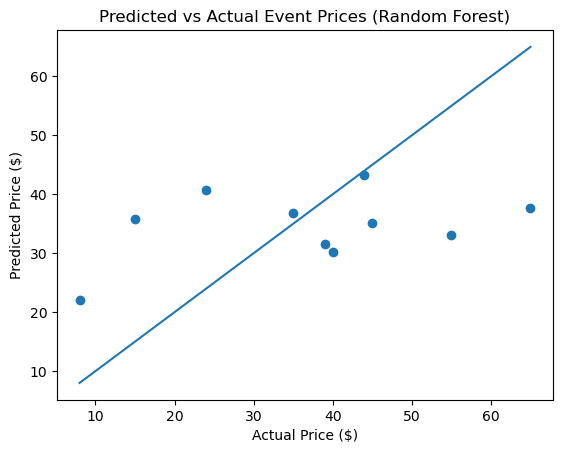

In [15]:
# Predictions vs Actual pricing
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, rf_preds)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Predicted vs Actual Event Prices (Random Forest)")
plt.show()

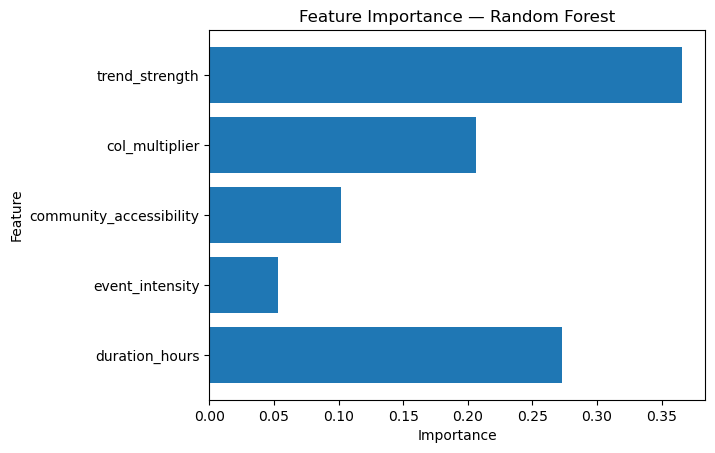

In [16]:
# Feature Importance plot
importances = rf_model.feature_importances_
feature_names = X.columns

plt.figure()
plt.barh(feature_names, importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance — Random Forest")
plt.show()

In [17]:
import joblib

joblib.dump(rf_model, "model.pkl")

['model.pkl']